# Image classification of Breast Ultra Sound Images

Here we experiment with classical algorithms such as Logistic Regression, SVM and Bag of Visual words


### Import packages

In [111]:
import os
import re
import random
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from sklearn.decomposition import PCA

from utils import init_img_dict, get_file_dicts, filter_files, find_mask, print_ndarray_info
from utils import img_read, img_write, img_resize, img_flip, comp_fft, histogram_equalization
from utils import display_img, display_img_list_3, display_3_imgs, display_3_hist, resize_imgs, flip_imgs, append_img_data

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, confusion_matrix 
from sklearn.preprocessing import StandardScaler

### Functions to assess model quality and to plot confusion matrix, ROC etc.

In [112]:
# Plot confusion matrix (binary)
def plot_cm(cm):
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.title("Confusion matrix")
    plt.show()
    

# Plot ROC
def plot_ROC(fpr, tpr, auc):

    plt.figure(figsize = (6.4, 6.4))
    plt.plot(fpr, tpr, label= f"ROC, auc= {auc:.2f}")
    plt.title("ROC curve")
    plt.legend(loc=4)
    plt.show()
    

# To assess model quality analysis
def model_quality(model, X_train, X_test, y_train, y_test):

    # Accuracy
    print(f"Model accuracy on training data: {model.score(X_train, y_train):.2f} ")
    print(f"Model accuracy on test data: {model.score(X_test, y_test):.2f} ")

    # Classification report (precision, recall, f1 score)
    print(f"\nClassification report:\n {classification_report(y_test, model.predict(X_test))} ")

    # Confusion matrix
    cm = confusion_matrix(y_test, model.predict(X_test))
    print(f"Confusion matrix:\n {cm}\n")
    plot_cm(cm)

    # ROC curve
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plot_ROC(fpr, tpr, auc)

# Get indices for True positives, True negatives, False positives and False negatives
def get_indices(model, X, y):

    y_pred = model.predict(X)
    tp_index = np.argwhere( (y == 1) & (y_pred == 1))
    tn_index = np.argwhere( (y == 0) & (y_pred == 0))
    fp_index = np.argwhere( (y == 0) & (y_pred == 1))
    fn_index = np.argwhere( (y == 1) & (y_pred == 0))

    return (tp_index, tn_index, fp_index, fn_index)


## Read image list (with dict object for each image) for the 2 classes (Benign and Malignant)
 - Read benign and malignant dataset into a list

In [113]:
img_res = 256

benign_img_dir = './Dataset_BUSI_with_GT/benign_256'
malignant_img_dir = './Dataset_BUSI_with_GT/malignant_256'

# Get a list of all images in a image directory
benign_img_list_all = get_file_dicts(benign_img_dir)
num_benign_img = len(benign_img_list_all)
print(f"Number of images in benign dataset: {num_benign_img}")

malignant_img_list_all = get_file_dicts(malignant_img_dir)
num_malignant_img = len(malignant_img_list_all)
print(f"Number of images in malignant dataset: {num_malignant_img}")

Number of images in benign dataset: 437
Number of images in malignant dataset: 420


## Prepare data for classification
 - Assemble feature data (pixels) and target data (0 for benign and 1 for malignant)
 - Shuffle the data
 - Split data in to training and test (70-30) set
 - Scale the data (use Standard scaler)

In [114]:
# Assemble feature and target data
img_data = np.empty((0, img_res*img_res), np.float32)

# Read and append images to img_data
#img_list = malignant_img_list_all[0:3:2]
img_list = benign_img_list_all + malignant_img_list_all
img_data = append_img_data(img_list, img_data)
print_ndarray_info(img_data, "Image feature data - benign + malignant")

# Create labels - 0 for benign and 1 for malignant
img_labels = np.array([0]*num_benign_img, dtype= np.int32)
img_labels = np.append(img_labels, np.array([1]*num_malignant_img, dtype= np.int32))

# Indices are used to recover images after shuffling
# indices 0 to num_benign_img - 1 is from benign and rest for malignant
indices = np.arange(0, num_benign_img + num_malignant_img, dtype= np.int32)

X, y = img_data, img_labels

print(img_data.shape)
print(img_labels.shape)

Image feature data - benign [ndim, shape, dtype, min, max]: [2, (437, 65536), float32, 0.0, 1.0]
Image feature data - benign + malignant [ndim, shape, dtype, min, max]: [2, (857, 65536), float32, 0.0, 1.0]
(857, 65536)
(857,)


In [115]:
# Shuffle and split data (keep same proportions of positive and negative in training and test set)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.3, random_state= 7, stratify= y)

# Scale training data and transform the test data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logistic regression (Regularization strength (inverse)= 1.0)

In [116]:
# Create a model and train
# solver= 'liblinear' 'lbfgs'
model = LogisticRegression(solver= 'liblinear', C= 1.0, random_state= 0)
model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

Model accuracy on training data: 1.00 
Model accuracy on test data: 0.75 

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.72      0.75       132
           1       0.73      0.78      0.75       126

    accuracy                           0.75       258
   macro avg       0.75      0.75      0.75       258
weighted avg       0.75      0.75      0.75       258
 
Confusion matrix:
 [[95 37]
 [28 98]]



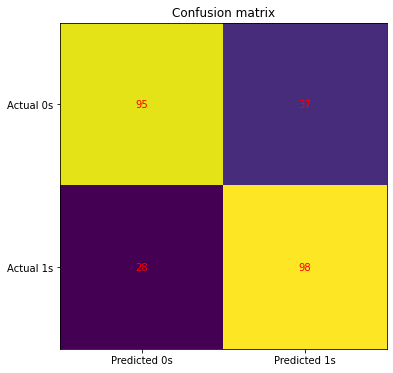

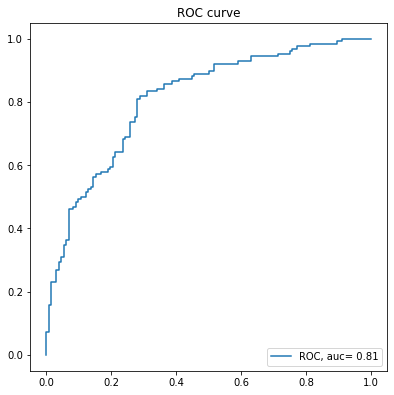

In [117]:
# Assess model quality
model_quality(model, X_train, X_test, y_train, y_test)

### Logistic regression (Regularization strength (inverse) = 0.001)

In [118]:
# Create a model and train
model2 = LogisticRegression(solver= 'liblinear', C= 0.001, random_state= 0)
model2.fit(X_train, y_train)

LogisticRegression(C=0.001, random_state=0, solver='liblinear')

Model accuracy on training data: 1.00 
Model accuracy on test data: 0.74 

Classification report:
               precision    recall  f1-score   support

           0       0.75      0.74      0.75       132
           1       0.73      0.75      0.74       126

    accuracy                           0.74       258
   macro avg       0.74      0.74      0.74       258
weighted avg       0.74      0.74      0.74       258
 
Confusion matrix:
 [[98 34]
 [32 94]]



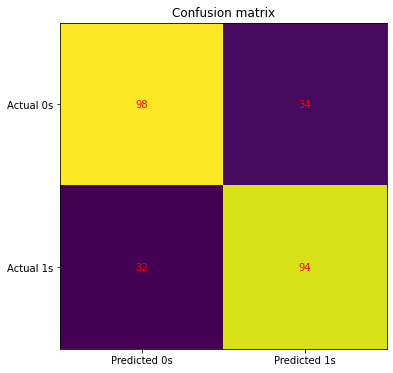

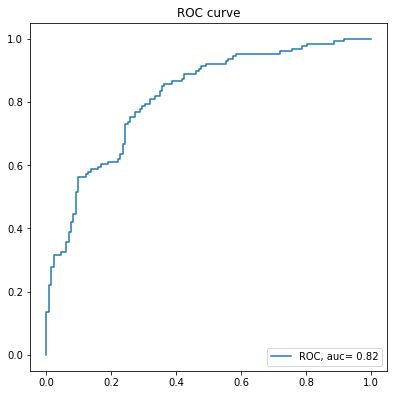

In [119]:
# Assess model quality
model_quality(model2, X_train, X_test, y_train, y_test)

### Logistic regression (Regularization strength (inverse) = 10.0)

In [120]:
# Create a model and train
model3 = LogisticRegression(solver= 'liblinear', C= 10, random_state= 0)
model3.fit(X_train, y_train)

LogisticRegression(C=10, random_state=0, solver='liblinear')

Model accuracy on training data: 1.00 
Model accuracy on test data: 0.75 

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75       132
           1       0.73      0.78      0.75       126

    accuracy                           0.75       258
   macro avg       0.75      0.75      0.75       258
weighted avg       0.75      0.75      0.75       258
 
Confusion matrix:
 [[96 36]
 [28 98]]



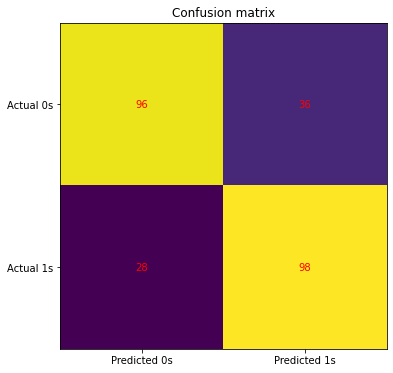

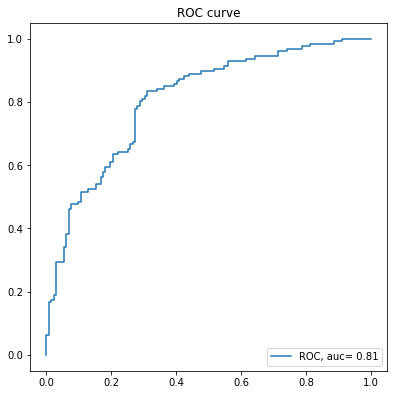

In [121]:
# Assess model quality
model_quality(model3, X_train, X_test, y_train, y_test)

In [122]:
# Show a few sample images from true positive, true negative, false positive and false negative
# Misclassified images: false positive and false negative
print_ndarray_info(indices, "Indices: ")
print_ndarray_info(indices_train, "Indices train: ")
print_ndarray_info(indices_test, "Indices test: ")
(tp_index, tn_index, fp_index, fn_index) = get_indices(model2, X_test, y_test)

# tp_index must be from malignant cases, tn_index from benign cases
# fp_index must be from benign and fn_index from malignant
# indices 0 to num_benign_img - 1 is from benign_img_list_all
# indices from num_benign_img to num_benign_img + num_malignant_img - 1 is from malignant_img_list_all
#print(num_benign_img)
#print(num_malignant_img)
#print(fp_index)
#print(fn_index)

#print(indices_test[fp_index])
#print(indices_test[fn_index] - num_benign_img)

Indices:  [ndim, shape, dtype, min, max]: [1, (857,), int32, 0, 856]
Indices train:  [ndim, shape, dtype, min, max]: [1, (599,), int32, 1, 856]
Indices test:  [ndim, shape, dtype, min, max]: [1, (258,), int32, 0, 853]
